# Using mhdx_tools Part 2: Extracting Signals and Quality Control
***

**The purpose of this notebook is to provide explanation and usage examples for the first half of the mhdx_tools.pipeline subpackage: the extract_timepoint_tensors, idotp_check, and idotp_filter modules.**

>These modules are responsible for the extraction of relevant signal, the determination of signal quality, and quality-based workflow pruning, respectively.

**The extract_timepoint_tensors module reads a .mzML.gz file, extracts a region of the 3D data around the center of identified signal for each line in library_info, and writes those extracted tensors to disk and/or returns them in a python dictionary.**

>The module relies on .mzML.gz files and library_info.csv from preprocessing, but no other inputs are needed.

>extract_timepoint_tensors has the 'indices' argument, which will limit extraction to a subset of library_info if a list of indices is passed. If no indices are passed, all lines in library_info are considered.

**The two 'IdotP' modules: idotp_check and idotp_filter, are used in Snakemake to reduce the number of candidate signals to be processed.** 
>The idotp_check Snakefile extracts signal from all undeuterated replicates for each entry in library_info.csv, uses the core classes to clean and deconvolute the data, and measures the quality of the observed signal against the theoretical isotopic distribution determined from the given protein's sequence. 

>The measure of quality used is the dot product between the observed and theoretical normalized integrated m/Z distributions (range [0,1]), or 'isotopic dot product' shortened to 'idotp'. A lower threshold on idotp is given to idotp_filter, which returns a set of indices from library_info.csv with idotp >= threshold. Lines in library_info.csv with poor idotp are not considered for further processing, crucially reducing computational load. 

>Default values for the idotp threshold are ~0.99 for extremely-high-confidence, and ~0.95 for high-confidence. Thresholds should be as close to 1 as possible to avoid excessive load and garbage-in-garbage-out problems, while retaining the highest identification-rate possible. The idotp_filter module creates plots of the idotp distribution, which help in making informed choices about idotp threshold.



In [5]:
import os
import sys
import yaml
import glob
import numpy as np
import pandas as pd
import seaborn as sns

# Set matplotlib backend to work in jupyter.
import matplotlib
# matplotlib.use("nbAgg") # best for windows but works on Mac
matplotlib.use("MacOSX") # best for notebooks on Mac
import matplotlib.pyplot as plt
%matplotlib inline

# Make the Jupyter environment see workflow/scripts/.
sys.path.append("/".join(os.getcwd().split("/")[:-1])+"/workflow/scripts") # default 'path/to/mhdx_tools-Pipeline/workflow/scripts/'
library_info = pd.read_csv("../resources/library_info/test_library_info.csv")
names_and_seqs = pd.read_csv("../resources/library_info/new_HX_order.csv")
config = yaml.load(open("../config/config.yaml", "rb").read(), Loader=yaml.FullLoader)

# Load and alias main functions of preprocessing modules
from mhdx_tools.pipeline.idotp_check import main as idotp_check
from mhdx_tools.pipeline.idotp_filter import main as idotp_filter
from mhdx_tools.pipeline.extract_timepoint_tensors import main as extract_timepoint_tensors
from mhdx_tools.pipeline.generate_tensor_ics import main as generate_tensor_ics
from mhdx_tools.pipeline.optimize_paths import main as optimize_paths

from mhdx_tools.io import limit_read, limit_write, optimize_paths_inputs

### Understanding library_info.csv

**Having created the library_info.csv from preprocessing, we're ready to look in detail at the signals identified and extract them for quality control and processing.**

>Here we begin by investigating the library_info.csv for error biases, dimensional distribution, and completeness of identification.

In [6]:
library_info['name']

0        HEEH_rd3_0224.pdb_4.24223
1        HEEH_rd3_0224.pdb_4.24223
2        HEEH_rd1_0966.pdb_4.24223
3        HEEH_rd1_0966.pdb_4.24223
4        HEEH_rd1_0966.pdb_4.24223
                   ...            
6862    HEEH_rd4_0866.pdb_18.91281
6863    HEEH_rd4_0276.pdb_18.97249
6864    HEEH_rd4_0246.pdb_19.11174
6865    HEEH_rd4_0528.pdb_19.31066
6866    HEEH_rd4_0528.pdb_19.31066
Name: name, Length: 6867, dtype: object

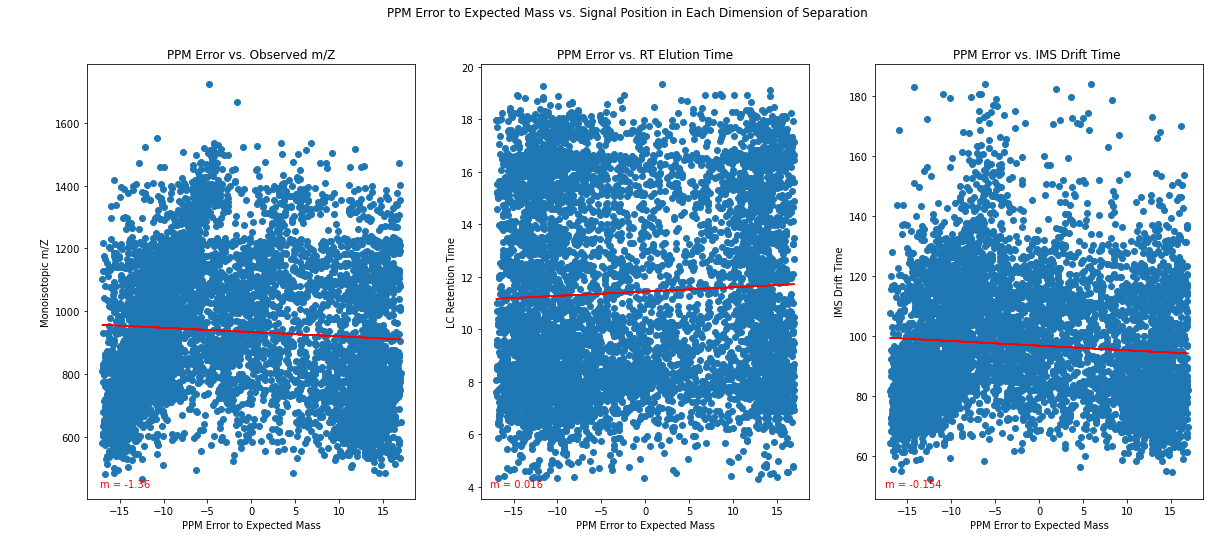

In [7]:
# Show scatterplots of PPM error vs. dimensional position to determine if there is a dimensionally-correlated error.

fig = plt.figure(figsize=(20,8))
plt.suptitle("PPM Error to Expected Mass vs. Signal Position in Each Dimension of Separation")

ax1 = fig.add_subplot(131)
x = library_info["ppm"]
y = library_info["obs_mz"]
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, m*x+b, color='r')
ax1.set(title="PPM Error vs. Observed m/Z", xlabel="PPM Error to Expected Mass", ylabel="Monoisotopic m/Z")
ax1.annotate("m = "+str(round(m, 3)), xy=(100,50), color="r", xycoords="figure points")

ax2 = fig.add_subplot(132)
x = library_info["ppm"]
y = library_info["RT"]
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, m*x+b, color='r')
ax2.set(title="PPM Error vs. RT Elution Time", xlabel="PPM Error to Expected Mass", ylabel="LC Retention Time")
ax2.annotate("m = "+str(round(m, 3)), xy=(490,50), color="r", xycoords="figure points")

ax3 = fig.add_subplot(133)
x = library_info["ppm"]
y = library_info["im_mono"]
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, m*x+b, color='r')
ax3.set(title="PPM Error vs. IMS Drift Time ", xlabel="PPM Error to Expected Mass", ylabel="IMS Drift Time")
ax3.annotate("m = "+str(round(m, 3)), xy=(885,50), color="r", xycoords="figure points")


plt.show()
plt.close()

**Observe the distribution of signals in each dimensional plane**

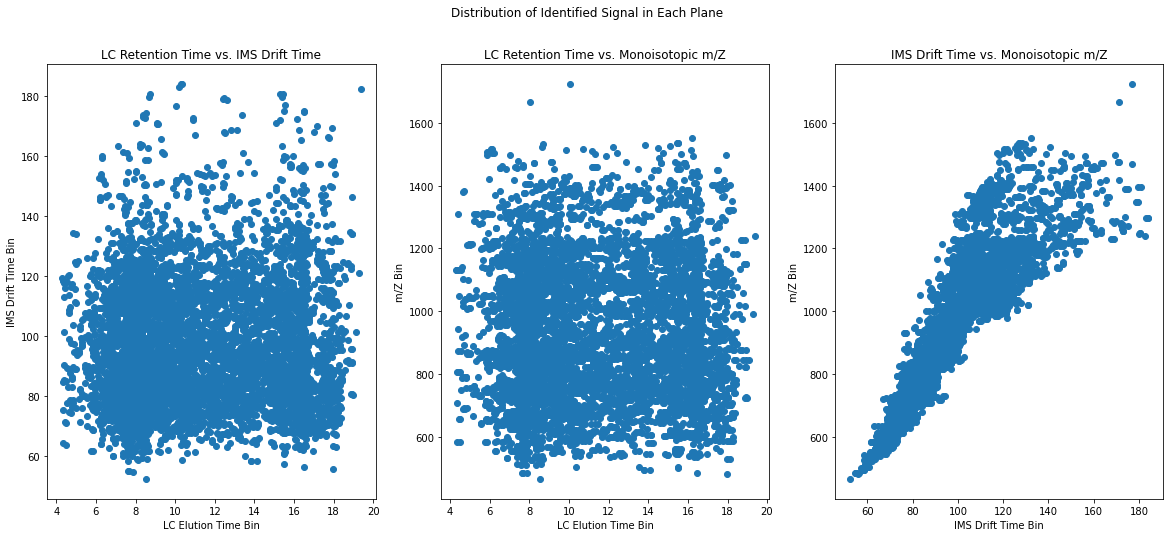

In [8]:
# Show scatterplots of density in each dimensional plane.

x = library_info["RT"]
y = library_info["im_mono"]
z = library_info["obs_mz"]

fig = plt.figure(figsize=(20,8))
plt.suptitle("Distribution of Identified Signal in Each Plane")

ax1 = fig.add_subplot(131)
plt.scatter(x, y)
ax1.set(title="LC Retention Time vs. IMS Drift Time", xlabel="LC Elution Time Bin", ylabel="IMS Drift Time Bin")

ax2 = fig.add_subplot(132)
plt.scatter(x, z)
ax2.set(title="LC Retention Time vs. Monoisotopic m/Z", xlabel="LC Elution Time Bin", ylabel="m/Z Bin")

ax3 = fig.add_subplot(133)
plt.scatter(y, z)
ax3.set(title="IMS Drift Time vs. Monoisotopic m/Z", xlabel="IMS Drift Time Bin", ylabel="m/Z Bin")


plt.show()
plt.close()

**Below, we consider groups of charged species together as an 'rt-group': a group of all the observed charge states of a library protein, clustered in LC retention time.**<br>
>This is necessary to limit the size of the LC extraction window, as our designed proteins have been observed to have bimodal elution profiles. 

>Clustering by elution-time can produce several rt-groups for each library protein, but these can be filtered with the idotp_check module to reduce computational load. 

>RT-group names are assigned during the creation of the library_info.csv, and here we create sub-dataframes from library_info for each rt_group.

In [9]:
# Divide library_info into rt-group level dataframes
lib_names = list(set(library_info["name"].values))
lib_names = sorted(lib_names, key=lambda i: float(i.split("_")[-1]))

rt_group_dfs = {}
for name in lib_names:
    rt_group_dfs[name] = library_info.loc[library_info["name"]==name]

In [10]:
# Check if each library protein has any line in library_info
grate = []
for name in names_and_seqs["name"].values:
    n_flag = False
    for lname in lib_names:
        if name in lname:
            n_flag = True
            break
    grate.append(n_flag)

n_covered = len([b for b in grate if b])
n_uncovered = len([b for b in grate if not b])
n_prots = len(names_and_seqs["name"])
print(str(n_covered)+" identified of "+str(n_prots)+" (%"+str(round(n_covered/n_prots, 3)*100)+")")

1177 identified of 1324 (%88.9)


***
## Extracting signals from .mzML.gz files

**The extract_timepoint_tensors module takes information from library_info to direct the extraction of relevant data from  .mzML.gz files**
>We use the .mzML.gz datatype for its random-access property, whereas .mzML files must be read sequentially. This allows us to reduce the total number of accessions to each file by skipping scans that contain no data to be extracted. 

>Because of the large time and processing overhead associated with opening the .mzML.gz file and reading each scan, the most efficient workflow for extract_timepoint_tensors is that represented in the preprocessing_snakefile: 
> 1. Replicates of the undeuterated timepoint should have signal tensors extracted for all library_info indices.
> 2. idotp_check and idotp_filter should be used to reduce the list of all library_info indices to those with quality signal.
> 3. Signal tensors should be extracted from deuterated timepoints for that subset of library_info indices. 

>This saves us the cost of extracting and processing low-quality signals, improving quality of time-series and reducing the total computing time of the pipeline.  

In [11]:
help(extract_timepoint_tensors)

Help on function main in module mhdx_tools.pipeline.extract_timepoint_tensors:

main(library_info_path, mzml_gz_path, timepoints_dict, outputs=None, return_flag=False, low_mass_margin=10, high_mass_margin=17, rt_radius=0.4, dt_radius_scale=0.06, polyfit_calibration_dict=None, indices=None)
    Reads through .mzML file and extracts subtensors whose dimensions are defined in 
       library_info.csv, optionally saves individual tensors or returns all as a dictionary.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        mzml_gz_path (str): path/to/timepoint.mzML.gz
        timepoints_dict (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        outputs (list of strings): list of filename strings for writing extracted outputs. 
        return_flag (bool): option to return main output in python, for notebook context
        low_mass_margin 

In [12]:
# Extract signal for a protein rt-group from an undeuterated MS run. 

# Select an rt-group by its lib_names index (sorted by LC-elution time), generate expected output filenames.
rt_group_name_idx = 13
indices_of_interest = rt_group_dfs[lib_names[rt_group_name_idx]]["Unnamed: 0"].values
desired_outputs = ["../resources/tensors/"+str(idx)+"_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib" for idx in indices_of_interest]

# Check if expected files are present, if not generate them. 
if all([len(list(glob.glob("../resources/tensors/"+str(idx)+"/"+str(idx)+"_*UN.*"))) > 0 for idx in indices_of_interest]): # only files from the replicate being used 
    rt_group_tensor_filenames = [fn for idx in indices_of_interest for fn in list(glob.glob("../resources/tensors/"+str(idx)+"/"+str(idx)+"_*"))]
    rt_group_undeut_filenames = [fn for fn in rt_group_tensor_filenames if "UN." in fn]
else:
    extract_timepoint_tensors(
        "../resources/library_info/library_info.csv", 
        "../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML.gz", 
        outputs=desired_outputs,
        timepoints_dict=config, 
        indices=indices_of_interest
    )
    if all([len(list(glob.glob("../resources/tensors/"+str(idx)+"/"+str(idx)+"_*UN.*"))) > 0 for idx in indices_of_interest]):
        rt_group_tensor_filenames = [fn for idx in indices_of_interest for fn in list(glob.glob("../resources/tensors/"+str(idx)+"/"+str(idx)+"_*"))]
        rt_group_undeut_filenames = [fn for fn in rt_group_tensor_filenames if "UN." in fn]


In [13]:
rt_group_undeut_filenames

['../resources/tensors/29_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib']

In [14]:
undeut_raw_tensors = [limit_read(fn) for fn in rt_group_undeut_filenames]

In [130]:
# and the third position contains the matricized intensity tensor along with each entry's m/Z label.
print("Overall output shape: \n"+str(np.shape(undeut_raw_tensors[0])))
print("Shape of each dimension:")
print(np.shape(undeut_raw_tensors[0][0]))
print(np.shape(undeut_raw_tensors[0][1]))
print(np.shape(undeut_raw_tensors[0][2]))
print("Shape of entry in mz-dimension: \n"+str(np.shape(undeut_raw_tensors[0][2][0])))

Overall output shape: 
(3,)
Shape of each dimension:
(48,)
(15,)
(720,)
Shape of entry in mz-dimension: 
(54, 2)


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



**The signals are 3D (LC-IMS-MS) arrays, and so are called tensors. These are saved as g-zipped pickle files, the filename of a tensor is passed to instances of the TensorGenerator class, and the explicit contents of the array are passed as arguments to the DataTensor class. These classes exist to simplify the user's role in the complex processing of these outputs.**

In [124]:
# This will take a long time to run, consider extracting all indices once instead.
# That will avoid additional computational load of opening a .mzML file repeatedly.
# Run extract_timepoint_tensors on all timepoints, for a single rt-group or remove indices argument to extract all lines of library_info.
rt_group_name_idx = 13
indices_of_interest = rt_group_dfs[lib_names[rt_group_name_idx]]["Unnamed: 0"].values
required_inputs = ['../resources/mzml/'+mzml+'.gz' for timepoint in config["timepoints"] for mzml in config[timepoint]]
# desired outputs stored as mzml-wise lists of outpaths.
desired_outputs = [["../resources/tensors/"+str(idx)+"/"+str(idx)+"_"+mzml+".gz.cpickle.zlib" for idx in indices_of_interest] for timepoint in config["timepoints"] for mzml in config[timepoint]]

for mzml, outputs in zip(required_inputs, desired_outputs):
    extract_timepoint_tensors(
        "../resources/library_info/library_info.csv", 
        mzml, 
        outputs=outputs,
        timepoints_dict=config, 
        indices=indices_of_interest
    )

FileNotFoundError: [Errno 2] No such file or directory: '../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML.gz'

In [121]:
# This will take a long time to run, do not use on rt-groups with many charge states. 
# Generate DataTensors and store their IsotopeClusters for the PathOptimizer
all_rt_group_ics = []
for tp in desired_outputs: # desired_outputs is the list of all rt-group TensorGenerator inputs. 
    timepoint_ics = []
    for fn in tp:
        outpath = "../resources/subtensor_ics/"+fn.split("/")[-1]
        tg = generate_tensor_ics(library_info_path="../resources/library_info/library_info.csv", tensor_input_path=fn, timepoints_dict=config, isotope_clusters_out_path=outpath, return_flag=True)["TensorGenerator"]
        for factor in tg.DataTensor.factors:
            for ic in factor.isotope_clusters:
                timepoint_ics.append(ic)
    all_rt_group_ics.append(timepoint_ics)

Pre-Initialization: 1.1624031066894531
Post-Initialization: 1.1751441955566406
0 Start Process Memory (GB): 1.1751441955566406
1 Read Params Process Memory (GB): 1.1786842346191406
2 Zeroing Process Memory (GB): 1.1786842346191406
3 Pre-Factorization Process Memory (GB): 1.1786842346191406
4 13 Factors  Start Process Memory (GB): 1.1786842346191406
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
4 13 Factors  End Process Memory (GB): 1.1974754333496094
5 12 Factors  Start Process Memory (GB): 1.1975364685058594
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
5 12 Factors  End Process Memory (GB): 1.1969337463378906
6 11 Factors  Start Process Memory 

***
## Generating a best-estimate hdx-mass-addition time series

**The hdx time series estimation is performed by instances of the PathOptimizer class. They take in all IsotopeClusteres from all charge-states of an rt-group, sample a starting set of plausible mass-addition curves, and optimize those starting curves by scoring with reference to the undeuterated ground-truth signal.**

The mhdx_tools.pipeline.optimize_paths module simply wraps PathOptimizer class for simple, easy instantiation.  

In [160]:
help(optimize_paths)

Help on function main in module mhdx_tools.pipeline.optimize_paths:

main(library_info_path, all_tensor_input_paths, timepoints, return_flag=False, rt_group_name=None, old_data_dir=None, html_plot_out_path=None, winner_out_path=None, runner_out_path=None, undeut_ground_out_path=None, winner_scores_out_path=None, rtdt_com_cvs_out_path=None)
    Uses PathOptimzier class to generate best-estimate hdx-timeseries of IsotopeClusters for a given library protein.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        all_tensor_input_paths (list of strings): list of paths/to/files.cpickle.zlib for all lists of IsotopeClusters from generate_tensor_ics.py
        timepoints (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        return_flag: option to return main output in python, for notebook context
        rt_group_name (str): library_info['na

In [7]:
# The io module function optimize_paths_inputs creates the flat list of IsotopeCluster-list files for an rt-group. This is sorted by the module.
ic_ins = optimize_paths_inputs(lib_names[rt_group_name_idx], library_info, config)
ic_ins = ["../"+fn for fn in ic_ins] # preprend ../ to adjust for working in /notebooks
print(len(ic_ins))

69


In [14]:
# Very slow, consider filtering to reduce total length of IC inputs
# Use the optimize_paths module on ICs from an rt-group to return a PathOptimizer object.
p1 = optimize_paths(
    "../resources/library_info/library_info.csv", 
    ic_ins, 
    config, 
    return_flag=True, 
    rt_group_name=lib_names[rt_group_name_idx], 
    html_plot_out_path="test_po_plot.html")["path_optimizer"] # output is a dictionary, use known key

**The optimize_paths module can output an interactive plot of the best-estimate time series as a .html file. This plot shows how each score term of the PathOptimizer contributed to the selection of one candidate IsotopeCluster over the others.**

***
## Using idotp_check to judge signal quality

**The idotp_check module performs a test on an extracted undeuterated signal to determine its similarity to the theoretical signal for the library protein sequence. This is the dot-product between the observed and theoretical isotope distributions, and so is shortened to 'idotp'.**
>Since our method estimates LC and IMS positions in deuterated-MS runs from the undeuterated signal, we ensure that the signals we are extrapolating from are high quality before moving on with the computationally intensive processing of deuterated signals. 

>In the provided idotp_check snakefile all undeuterated protein are extracted, ensuring that only signals with high-undeuterated-idotp are extracted from later hdx time points, reducing disk usage.


In [69]:
help(idotp_check)

Help on function main in module mhdx_tools.pipeline.idotp_check:

main(library_info_path, undeut_tensor_path_list, output_path=None, return_flag=None, n_factors=15, gauss_params=(3, 1))
    Compares each undeuterated charge state of an rt-group to its theoretical distribution to determine signal quality.
    
    Args:
        library_info_path (string): path/to/library_info.csv
        undeut_tensor_path_list (list of strings): list of paths/to/files.cpickle.zlib
        output_path (string): path/to/output.csv
        return_flag (bool): option to return output in python, for notebook context
        n_factors (int): high number of factors to start factorization with
        gauss_params (tuple of floats): gaussian smoothing parameters in tuple (rt-sigma, dt-sigma), default (3,1)
    
    Returns:
        iso_cluster_list (list): list of IsotopeCluster objects produced from factorized input tensors
        data_tensor_list (list): list of DataTensor objects produced from input tensor

In [73]:
# In the python context, use glob to capture all undeuterated tensors, or restrict to a subset of library_info indices.
all_undeut_tensors = list(glob.glob("../resources/tensors/*UN*"))
rt_group_undeut_tensors = [fn for idx in indices_of_interest for fn in all_undeut_tensors if "/"+str(idx)+"_" in fn]

# Write a set of expected filenames to test.
all_expected_rt_group_tensors = ["../resources/tensors/"+str(index)+"_"+fn+".gz.cpickle.zlib" for timepoint in config["timepoints"] for fn in config[timepoint] for index in indices_of_interest]
undeut_expected_rt_group_tensors = [fn for idx in indices_of_interest for fn in all_expected_rt_group_tensors if "/"+str(idx)+"_" in fn and "UN" in fn]

In [74]:
# Check for expected undeuterated files in globbed list
all([fn in all_undeut_tensors for fn in undeut_expected_rt_group_tensors])

True

In [84]:
rt_group_undeut_tensors

['../resources/tensors/19_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/19_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib',
 '../resources/tensors/19_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib']

In [77]:
# Run idotp_check on all charge states of an rt_group
idc = idotp_check("../resources/library_info/library_info.csv", rt_group_undeut_tensors, return_flag=True)

['../resources/tensors/19_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/19_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib', '../resources/tensors/19_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib']
0 Start Process Memory (GB): 0.22813796997070312
1 Read Params Process Memory (GB): 0.2318572998046875
2 Zeroing Process Memory (GB): 0.2318572998046875
3 Pre-Factorization Process Memory (GB): 0.2318572998046875
4 15 Factors  Start Process Memory (GB): 0.2318572998046875
Irrelevant number of sparsity coefficient (different f

In [78]:
# idc is a dictionary
idc.keys()

dict_keys(['iso_clusters_list', 'data_tensor_list', 'idotp_list', 'integrated_mz_list'])

In [86]:
# The total number of IsotopeClusters identified from the input tensors
len(idc["idotp_list"])

824

In [96]:
# Count and percent of total for IsotopeClusters with idotp > 0.95 and 0.99
(len([idotp for idotp in idc["idotp_list"] if idotp>0.95]), 
 len([idotp for idotp in idc["idotp_list"] if idotp>0.95])/len(idc["idotp_list"])*100, 
 len([idotp for idotp in idc["idotp_list"] if idotp>0.99]), 
 len([idotp for idotp in idc["idotp_list"] if idotp>0.99])/len(idc["idotp_list"])*100)

(71, 8.616504854368932, 15, 1.820388349514563)

../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib


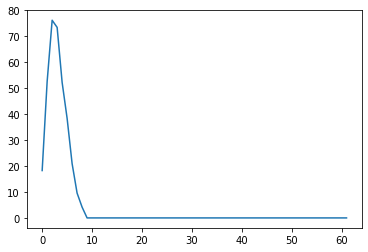

In [103]:
# Plot IsotopeCluster with highest idotp and print sourcefile.
best_idx = np.argmax(idc["idotp_list"])
print(idc["iso_clusters_list"][best_idx].source_file)
plt.plot(idc["iso_clusters_list"][best_idx].baseline_integrated_mz)

0.9916463002373997


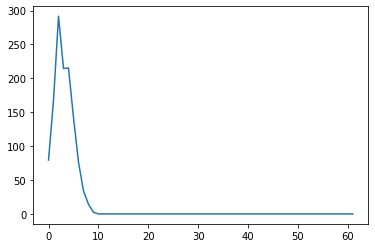

0.9912131421350864


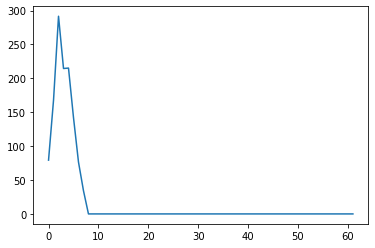

0.9948669424320942


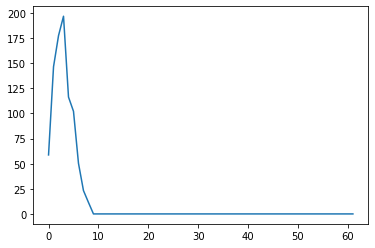

0.9923624731449346


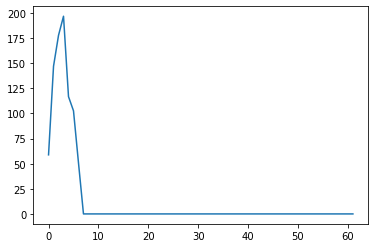

0.9967651993804943


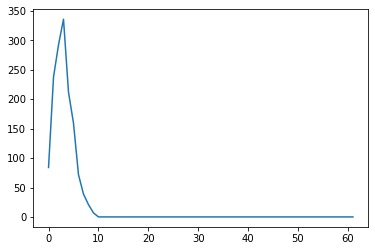

0.9908642121060086


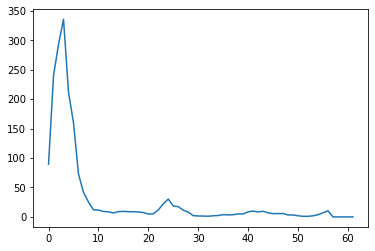

0.9942577665291881


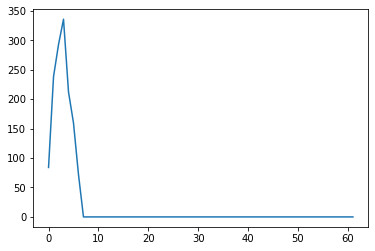

0.9924051308344518


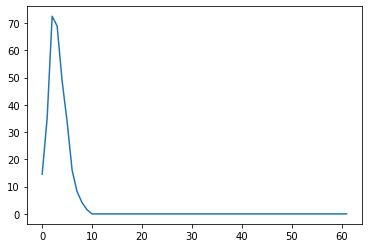

0.9971533897785265


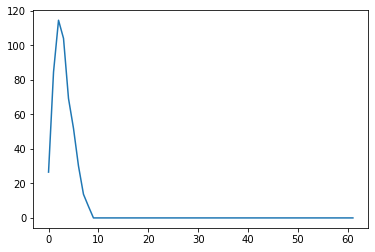

0.9935263262184206


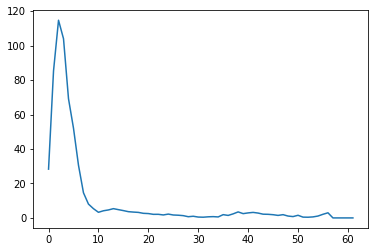

0.9946574625361586


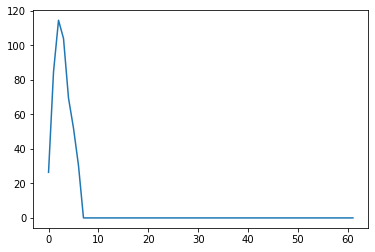

0.9990264538353882


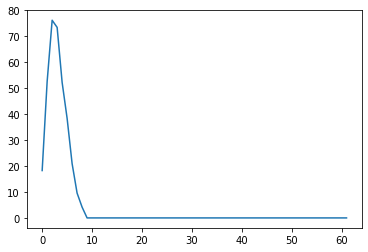

0.9950285318836749


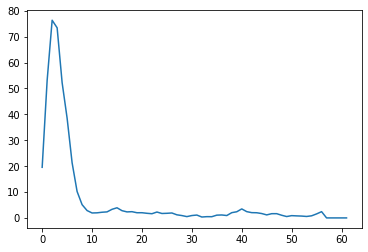

0.9965076136166259


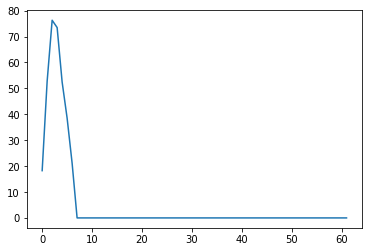

0.9911876088387782


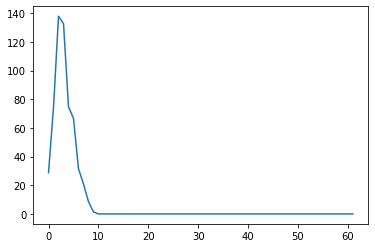

In [105]:
# Plot ICs with idotp>0.99
for ic, idotp in zip(idc["iso_clusters_list"], idc["idotp_list"]):
    if idotp > 0.99:
        print(idotp)
        plt.figure()
        plt.plot(ic.baseline_integrated_mz)
        plt.show()
        plt.close()

***
## Ignoring poor signals with idotp_filter

**The idotp_filter is a very simple module that reads the set of all idotp_check output .csv files, and returns a list of library_info indices with idotp. The list of indices is passed as an argument to extract_timepoint_tensors to ensure that we don't waste disk-space by exttracting tensors for library_info entries that have proven to have poor undeuterated signal.**

>The idotp_filter module takes an arbitrary number of input .csv files and a floor value for idotp between 0 and 1, and outputs one csv file with one column: 'filter_passing_indices' or returns a dictionary with the same key in python. 

In [106]:
help(idotp_filter)

Help on function main in module mhdx_tools.pipeline.idotp_filter:

main(all_idotp_csv_inputs, out_path=None, return_flag=False, idotp_cutoff=0.95)
    Reads all rt-group idotp csvs and returns or saves a list of indices with idotp >= idotp_cutoff.
    
    Args:
        all_idotp_csv_inputs (list of strings): list of all input IsotopeCluster-list filepaths
        out_path (str): path/to/file for main output.cpickle.zlib
        return_flag (bool): option to return main output in python, for notebook context
        idotp_cutoff (float): inclusive lower-bound on idotp [0,1] to be considered for evaluation, default=0.95
    
    Returns:
        out_dict (dict) = dictionary containing 'filter_passing_indices'



In [117]:
# collect any existing idotp_check files
idotp_filter_inputs = glob.glob("../resources/idotp_filter/*.csv")

In [119]:
idpf = idotp_filter(idotp_filter_inputs, return_flag=True, idotp_cutoff=0.99)

In [122]:
len(library_info), len(idpf["filter_passing_indices"])

(1755, 1853)

In [123]:
idpf["filter_passing_indices"]

[1,
 2,
 4,
 5,
 15,
 16,
 17,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 32,
 33,
 35,
 36,
 37,
 43,
 48,
 49,
 50,
 51,
 59,
 60,
 61,
 63,
 71,
 72,
 73,
 82,
 83,
 84,
 88,
 89,
 90,
 93,
 94,
 95,
 96,
 98,
 99,
 101,
 104,
 106,
 111,
 116,
 119,
 120,
 121,
 122,
 123,
 124,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 143,
 148,
 149,
 150,
 155,
 156,
 157,
 165,
 170,
 172,
 174,
 175,
 176,
 182,
 185,
 186,
 187,
 188,
 191,
 192,
 194,
 198,
 201,
 202,
 203,
 204,
 205,
 209,
 210,
 211,
 214,
 221,
 223,
 224,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 236,
 237,
 241,
 242,
 244,
 245,
 251,
 254,
 255,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 272,
 275,
 276,
 280,
 281,
 282,
 288,
 290,
 294,
 298,
 299,
 300,
 301,
 303,
 304,
 306,
 308,
 310,
 315,
 321,
 322,
 325,
 326,
 328,
 329,
 330,
 332,
 335,
 336,
 338,
 340,
 341,
 347,
 349,
 350,
 353,
 354,
 356,
 357,
 358,
 359,
 363,
 365,
 366,
 373,
 377,
 380,
 383,
 384,
 385,
 393,
 394,
 395,
 397,
 40